# Análisis sociodemográfico de un área de interés

This notebook takes as input a gdf containing censo data, transforms dtypes for columns with data to float type and makes a summary out of fields of interest.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
# Cuenca del arroyo vivo
#aoi_name = 'arroyovivo_cuenca'
#dir = f'../../data/external/temporal_todocker/arroyo_vivo/cuenca_arroyo_32614.gpkg'
#output = f'../../data/external/temporal_fromjupyter/arroyo_vivo/censoanalysis_for_{aoi_name}.csv'

# Polígono del proyecto que ellos tienen originalmente
#aoi_name = 'poligono_arroyovivo'
#dir = f'../../data/external/temporal_todocker/arroyo_vivo/poligono_proyectoarroyovivo_32614.gpkg'
#output = f'../../data/external/temporal_fromjupyter/arroyo_vivo/censoanalysis_for_{aoi_name}.csv'

# Buffer de 200 metros al arroyo (principal)
#aoi_name = 'buffer_200mts'
#dir = f'../../data/external/temporal_todocker/arroyo_vivo/arroyo_buffer200mts_32614.gpkg'
#output = f'../../data/external/temporal_fromjupyter/arroyo_vivo/censoanalysis_for_{aoi_name}.csv'

## Config notebook

In [3]:
# Name and location of area of interest (aoi)
aoi_name = 'div_04'
aoi_dir = f'../../data/external/temporal_todocker/arroyo_vivo/04_cuenca_baja_32614.gpkg'

# Save base censo data with str columns changed to decimal?
refactored_output = False
refactored_output_dir = '../../data/external/temporal_fromjupyter/arroyo_vivo/censo_mza_2020_cuenca_refactored.gpkg'

# Save csv final output?
analysis_output = True
analysis_output_dir = f'../../data/external/temporal_fromjupyter/arroyo_vivo/censoanalysis_for_{aoi_name}.csv'

## Download base data

### Download - Area of interest

<Axes: >

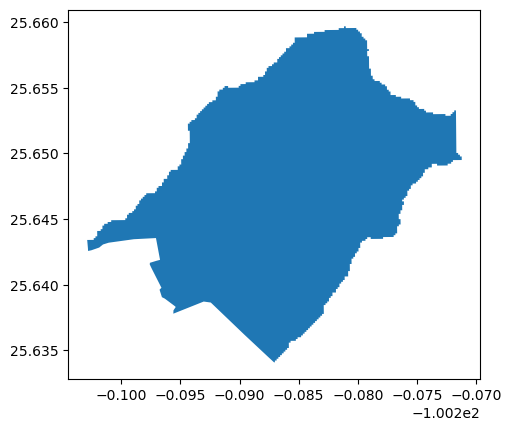

In [4]:
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

# Show
aoi.plot()

### Download - Censo 2020 for aoi

In [5]:
censo_gdf = aup.gdf_from_polygon(aoi,'censo_mza','censo_mza_2020')

# Show
print(censo_gdf.shape)
censo_gdf.head(1)

(337, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,1903900012082031,19,039,0001,2082,031,Urbana,Típica,"POLYGON ((-100.29723 25.64689, -100.29726 25.6...",19,...,14,17,17,15,12,6,0,0,None,0


<Axes: >

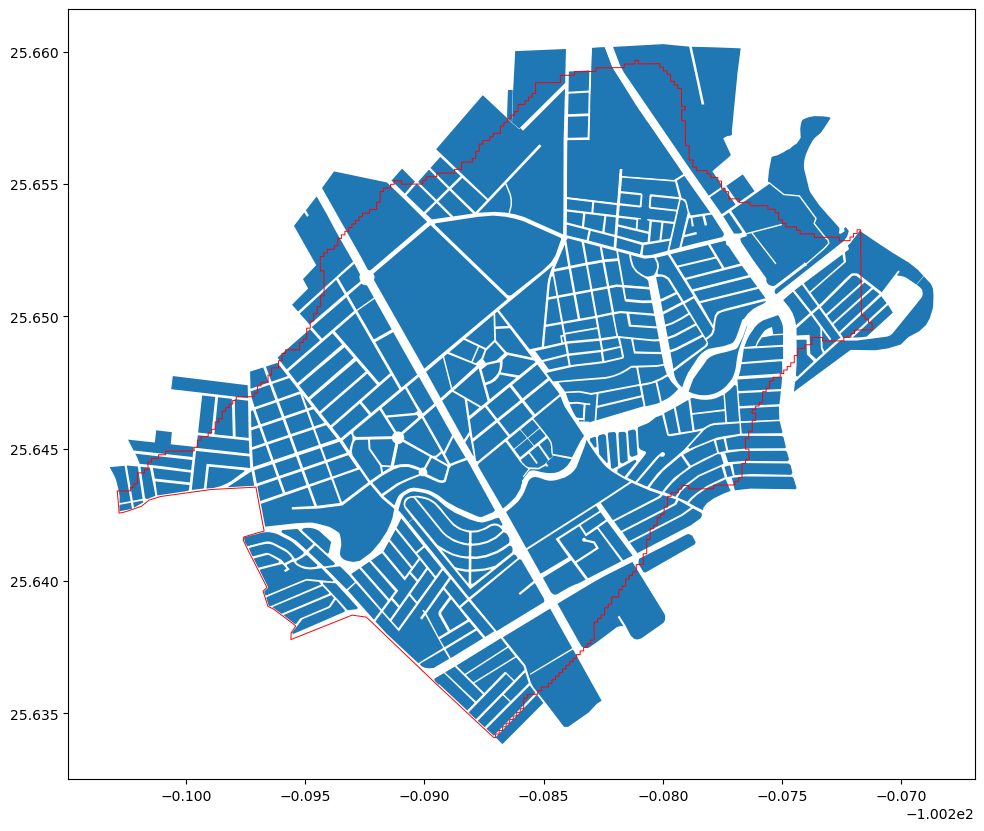

In [6]:
fig,ax = plt.subplots(figsize=(20,10))
censo_gdf.plot(ax=ax,zorder=1)
aoi.plot(ax=ax,zorder=2,facecolor="none", edgecolor='red', lw=0.7)

## Data treatment

### Data treatment - Transform data (refactor fields)

In [7]:
censo_gdf.dtypes

CVEGEO         object
CVE_ENT        object
CVE_MUN        object
CVE_LOC        object
CVE_AGEB       object
                ...  
VPH_CVJ        object
VPH_SINRTV     object
VPH_SINLTC     object
VPH_SINCINT    object
VPH_SINTIC     object
Length: 239, dtype: object

In [8]:
# All columns
columns_list = list(censo_gdf.columns)
# Columns which we are not interested in changing
loc_str_cols = ['CVEGEO','CVE_ENT','CVE_MUN','CVE_LOC','CVE_AGEB','CVE_MZA',
                'AMBITO','TIPOMZA','ENTIDAD','NOM_ENT','MUN','NOM_MUN','LOC','NOM_LOC','AGEB','MZA','geometry']

loc_float_cols = []

for col in columns_list:
    # Skip loc_str_cols
    if col in loc_str_cols:
        continue
    # Transform to numeric column
    censo_gdf[col] = censo_gdf[col].astype(float)
    loc_float_cols.append(col)
    
# Show
censo_gdf.dtypes

CVEGEO          object
CVE_ENT         object
CVE_MUN         object
CVE_LOC         object
CVE_AGEB        object
                ...   
VPH_CVJ        float64
VPH_SINRTV     float64
VPH_SINLTC     float64
VPH_SINCINT    float64
VPH_SINTIC     float64
Length: 239, dtype: object

In [9]:
if refactored_output:
    censo_gdf.to_file(refactored_output_dir)

### Data treatment - Calculations

In [10]:
# Calculate missing age group
censo_gdf['P_25A59'] = censo_gdf['P_18YMAS'] - censo_gdf['P_18A24'] - censo_gdf['P_60YMAS']
censo_gdf['P_25A59_F'] = censo_gdf['P_18YMAS_F'] - censo_gdf['P_18A24_F'] - censo_gdf['P_60YMAS_F']
censo_gdf['P_25A59_M'] = censo_gdf['P_18YMAS_M'] - censo_gdf['P_18A24_M'] - censo_gdf['P_60YMAS_M']

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

## Data analysis

### Data analysis - Set relevant censo data for analysis

In [11]:
socio_age_data = ['POBTOT','POBFEM','POBMAS',
                  'P_0A2','P_0A2_F','P_0A2_M',
                  'P_3A5','P_3A5_F','P_3A5_M',
                  'P_6A11','P_6A11_F','P_6A11_M',
                  'P_12A14','P_12A14_F','P_12A14_M',
                  'P_15A17','P_15A17_F','P_15A17_M',
                  'P_18A24','P_18A24_F','P_18A24_M',
                  'P_25A59','P_25A59_F','P_25A59_M',
                  'P_60YMAS','P_60YMAS_F','P_60YMAS_M']

auxiliar_age_data = ['P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                     'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                     'P_15YMAS','P_15YMAS_F','P_15YMAS_M']

etnicity_data = ['P3YM_HLI','P3YM_HLI_F','P3YM_HLI_M']

discapacity_data = ['PCON_DISC','PCON_LIMI']

education_data = ['P3A5_NOA','P3A5_NOA_F','P3A5_NOA_M',
                  'P6A11_NOA','P6A11_NOAF','P6A11_NOAM',
                 'P15YM_AN','P15YM_AN_F','P15YM_AN_M']

avg_education_data = ['GRAPROES','GRAPROES_F','GRAPROES_M']

economic_data = ['PEA','PEA_F','PEA_M',
                 'POCUPADA','POCUPADA_F','POCUPADA_M']

health_data = ['PSINDER']

house_data = ['VIVTOT',
              'HOGJEF_F',
              'TVIVPARHAB',
              'VPH_PISOTI',
              'VPH_C_ELEC','VPH_S_ELEC',
              'VPH_AGUADV','VPH_AGUAFV',
              'VPH_LETR','VPH_DRENAJ','VPH_NODREN',
              'VPH_NDACMM','VPH_AUTOM','VPH_MOTO','VPH_BICI',
              'VPH_INTER','VPH_SINTIC']
              
avg_house_data = ['PROM_OCUP',
                  'PRO_OCUP_C']

sum_data = socio_age_data + auxiliar_age_data + etnicity_data + discapacity_data + education_data + economic_data + health_data + house_data
avg_data = avg_education_data + avg_house_data

In [12]:
summary_gdf = pd.DataFrame()

i = 0
for column in sum_data:
    data = censo_gdf[column].sum()
    summary_gdf.loc[i,'indicador'] = column
    summary_gdf.loc[i,'data'] = data
    i = i+1
    
summary_gdf

,indicador,data
0,POBTOT,31874.0
1,POBFEM,15650.0
2,POBMAS,15856.0
3,P_0A2,343.0
4,P_0A2_F,98.0
...,...,...
69,VPH_AUTOM,8822.0
70,VPH_MOTO,453.0
71,VPH_BICI,851.0
72,VPH_INTER,10516.0


In [13]:
wgt_dicc = {'POBTOT':['POBFEM','POBMAS','P_0A2','P_3A5','P_6A11','P_12A14','P_15A17','P_18A24','P_25A59','P_60YMAS', # Age groups
                      'P_3YMAS','P_12YMAS','P_15YMAS', #Auxiliar age groups
                      'PCON_DISC','PCON_LIMI', #Discapacity
                      'PSINDER', #Health
                     ],
            'POBFEM':['P_0A2_F','P_3A5_F','P_6A11_F','P_12A14_F','P_15A17_F','P_18A24_F','P_25A59_F','P_60YMAS_F', # Age groups
                      'P_3YMAS_F','P_12YMAS_F','P_15YMAS_F', #Auxiliar age groups
                      ],
            'POBMAS':['P_0A2_M','P_3A5_M','P_6A11_M','P_12A14_M','P_15A17_M','P_18A24_M','P_25A59_M','P_60YMAS_M', # Age groups
                      'P_3YMAS_M','P_12YMAS_M','P_15YMAS_M', #Auxiliar age groups
                      ],
            'P_3YMAS':['P3YM_HLI'], #Etnicity
            'P_3YMAS_F':['P3YM_HLI_F'], #Etnicity
            'P_3YMAS_M':['P3YM_HLI_M'], #Etnicity,
            'P_3A5':['P3A5_NOA'], #Education
            'P_3A5_F':['P3A5_NOA_F'], #Education
            'P_3A5_M':['P3A5_NOA_M'], #Education
            'P_6A11':['P6A11_NOA'], #Education
            'P_6A11_F':['P6A11_NOAF'], #Education
            'P_6A11_M':['P6A11_NOAM'], #Education            
            'P_15YMAS':['P15YM_AN'], #Education
            'P_15YMAS_F':['P15YM_AN_F'], #Education
            'P_15YMAS_M':['P15YM_AN_M'], #Education
            'P_12YMAS':['PEA','POCUPADA'], #Economy
            'P_12YMAS_F':['PEA_F','POCUPADA_F'], #Economy
            'P_12YMAS_M':['PEA_M','POCUPADA_M'], #Economy
            'VIVTOT':['TVIVPARHAB'], #House
            'TVIVPARHAB':['HOGJEF_F','VPH_PISOTI','VPH_C_ELEC','VPH_S_ELEC','VPH_AGUADV','VPH_AGUAFV','VPH_LETR','VPH_DRENAJ', #House
                          'VPH_NODREN','VPH_NDACMM','VPH_AUTOM','VPH_MOTO','VPH_BICI','VPH_INTER','VPH_SINTIC' #House
                         ]
           } 

In [14]:
for k in wgt_dicc.keys():
    for column in wgt_dicc[k]:
        
        idx_1 = summary_gdf.indicador == column
        data = summary_gdf.loc[idx_1].data.unique()[0]
        print(f'Column {column} data: {data}')
        
        idx_2 = summary_gdf.indicador == k
        weight_data = summary_gdf.loc[idx_2].data.unique()[0]
        print(f'Weight column {k} data: {weight_data}')
        
        wgt_pct = (data/weight_data)*100
        #print(f'Weight data: {wgt_pct}%')
        
        summary_gdf.loc[idx_1,'wgt_%'] = wgt_pct
        summary_gdf.loc[idx_1,'weight'] = k
        
summary_gdf

Column POBFEM data: 15650.0
Weight column POBTOT data: 31874.0
Column POBMAS data: 15856.0
Weight column POBTOT data: 31874.0
Column P_0A2 data: 343.0
Weight column POBTOT data: 31874.0
Column P_3A5 data: 419.0
Weight column POBTOT data: 31874.0
Column P_6A11 data: 932.0
Weight column POBTOT data: 31874.0
Column P_12A14 data: 364.0
Weight column POBTOT data: 31874.0
Column P_15A17 data: 448.0
Weight column POBTOT data: 31874.0
Column P_18A24 data: 5065.0
Weight column POBTOT data: 31874.0
Column P_25A59 data: 13291.0
Weight column POBTOT data: 31874.0
Column P_60YMAS data: 6755.0
Weight column POBTOT data: 31874.0
Column P_3YMAS data: 28574.0
Weight column POBTOT data: 31874.0
Column P_12YMAS data: 26907.0
Weight column POBTOT data: 31874.0
Column P_15YMAS data: 26348.0
Weight column POBTOT data: 31874.0
Column PCON_DISC data: 1111.0
Weight column POBTOT data: 31874.0
Column PCON_LIMI data: 3266.0
Weight column POBTOT data: 31874.0
Column PSINDER data: 3702.0
Weight column POBTOT data:

,indicador,data,wgt_%,weight
0,POBTOT,31874.0,NaN,NaN
1,POBFEM,15650.0,49.099580,POBTOT
2,POBMAS,15856.0,49.745874,POBTOT
3,P_0A2,343.0,1.076112,POBTOT
4,P_0A2_F,98.0,0.626198,POBFEM
...,...,...,...,...
69,VPH_AUTOM,8822.0,78.313360,TVIVPARHAB
70,VPH_MOTO,453.0,4.021305,TVIVPARHAB
71,VPH_BICI,851.0,7.554372,TVIVPARHAB
72,VPH_INTER,10516.0,93.351087,TVIVPARHAB


In [15]:
summary_gdf.head(35)

,indicador,data,wgt_%,weight
0,POBTOT,31874.0,NaN,NaN
1,POBFEM,15650.0,49.099580,POBTOT
2,POBMAS,15856.0,49.745874,POBTOT
3,P_0A2,343.0,1.076112,POBTOT
4,P_0A2_F,98.0,0.626198,POBFEM
5,P_0A2_M,117.0,0.737891,POBMAS
6,P_3A5,419.0,1.314551,POBTOT
7,P_3A5_F,151.0,0.964856,POBFEM
8,P_3A5_M,140.0,0.882947,POBMAS
9,P_6A11,932.0,2.924013,POBTOT


In [16]:
summary_gdf.tail(39)

,indicador,data,wgt_%,weight
35,P_15YMAS_M,13269.0,83.684410,POBMAS
36,P3YM_HLI,51.0,0.178484,P_3YMAS
37,P3YM_HLI_F,14.0,0.098598,P_3YMAS_F
38,P3YM_HLI_M,18.0,0.125226,P_3YMAS_M
39,PCON_DISC,1111.0,3.485600,POBTOT
40,PCON_LIMI,3266.0,10.246596,POBTOT
41,P3A5_NOA,44.0,10.501193,P_3A5
42,P3A5_NOA_F,18.0,11.920530,P_3A5_F
43,P3A5_NOA_M,9.0,6.428571,P_3A5_M
44,P6A11_NOA,3.0,0.321888,P_6A11


In [17]:
if analysis_output:
    summary_gdf.to_csv(analysis_output_dir)